# Ablating neurons in an ensemble

The model used here is a simple controlled integrator,
as is shown in
[this core Nengo
example](https://www.nengo.ai/nengo/examples/dynamics/controlled-integrator.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo.processes import Piecewise

In [2]:
with nengo.Network(label="Controlled Integrator") as model:
    input_func = Piecewise({0: 0, 0.2: 5, 0.3: 0, 0.44: -10, 0.54: 0, 0.8: 5, 0.9: 0})
    control_func = Piecewise({0: 1, 0.6: 0.5})

    tau = 0.1

    stim = nengo.Node(input_func)
    control = nengo.Node(output=control_func)
    ens = nengo.Ensemble(225, dimensions=2, radius=1.5)
    nengo.Connection(stim, ens, transform=[[tau], [0]], synapse=tau)
    nengo.Connection(control, ens[1])

    nengo.Connection(ens, ens[0], function=lambda x: x[0] * x[1], synapse=tau)

    ens_probe = nengo.Probe(ens, synapse=0.01)

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(1.4)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

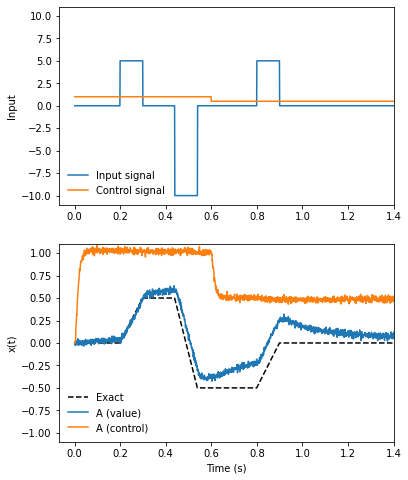

In [4]:
def plot():
    t = sim.trange()
    input_sig = input_func.run(sim.time)
    control_sig = control_func.run(sim.time)
    ref = sim.dt * np.cumsum(input_sig)

    plt.figure(figsize=(6, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, input_sig, label="Input signal")
    plt.plot(t, control_sig, label="Control signal")
    plt.xlim(right=t[-1])
    plt.ylim(-11, 11)
    plt.ylabel("Input")
    plt.legend(loc="lower left", frameon=False)

    plt.subplot(2, 1, 2)
    plt.plot(t, ref, "k--", label="Exact")
    plt.plot(t, sim.data[ens_probe][:, 0], label="A (value)")
    plt.plot(t, sim.data[ens_probe][:, 1], label="A (control)")
    plt.xlim(right=t[-1])
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Time (s)")
    plt.ylabel("x(t)")
    plt.legend(loc="lower left", frameon=False)


plot()

The model is composed primarily of a single two-dimensional ensemble.
The first dimension takes in input;
the second dimension is a control signal.
The ensemble is recurrently connected such that
the ensemble integrates the input signal
in its first dimension,
as long as the control dimension is near 1.
As can be seen above, it performs as expected.

We can emulate the effects of ablating neurons in an ensemble
(or, equivalently, the input connections to those neurons)
by setting the encoder associated with them to 0.
If we wish to fully ablate the neurons
and silence them entirely,
we can inject a constant negative current into them.
We'll make a helper function so that we can do this
for any ensemble.

In [5]:
def ablate_ensemble(ens, proportion, sim, bias=True):
    """Ablate a proportion of the neurons in an ensemble.

    The ablation is done by setting the encoder and gain associated
    with a neuron to zero. Since no input current being injected,
    the neuron will generally be silent. However, if there is direct
    current injected with a neuron-to-neuron connection, then the
    cell may still fire. To counter that in most cases, we set the
    bias associated with the neuron to a large negative value.
    """

    n_neurons = min(int(ens.n_neurons * proportion), ens.n_neurons)
    idx = np.random.choice(np.arange(ens.n_neurons), replace=False, size=n_neurons)

    encoder_sig = sim.signals[sim.model.sig[ens]["encoders"]]
    encoder_sig.setflags(write=True)
    encoder_sig[idx] = 0.0
    encoder_sig.setflags(write=False)

    if bias:
        bias_sig = sim.signals[sim.model.sig[ens.neurons]["bias"]]
        bias_sig.setflags(write=True)
        bias_sig[idx] = -1000

Note that this function requires a built `Simulator`.
This is because decoders are determined during
the build process, and do not exist when the model
is originally specified.

Let's see the effects of ablating 1% of the 225 neurons
in the ensemble.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

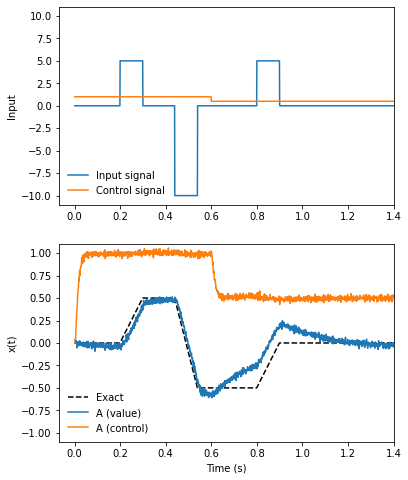

In [6]:
with nengo.Simulator(model) as sim:
    ablate_ensemble(ens, 0.01, sim)
    sim.run(1.4)
plot()

Not much happened. Let's bump this up to 10% of the 225 neurons.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

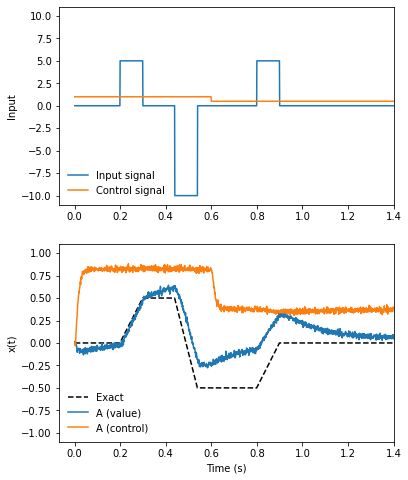

In [7]:
with nengo.Simulator(model) as sim:
    ablate_ensemble(ens, 0.1, sim)
    sim.run(1.4)
plot()

Still not bad, but getting worse. How about 25%?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

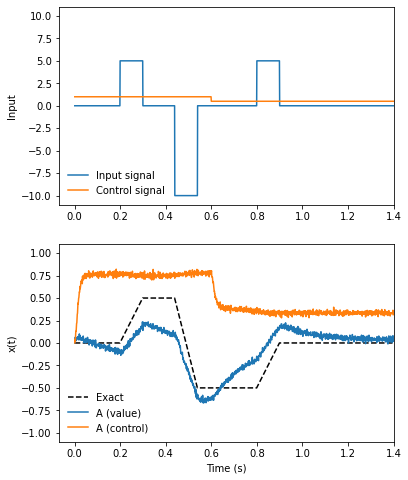

In [8]:
with nengo.Simulator(model) as sim:
    ablate_ensemble(ens, 0.25, sim)
    sim.run(1.4)
plot()

To verify that this is indeed working as expected,
we can ablate all of the neurons and confirm that
there is no activity in the ensemble.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

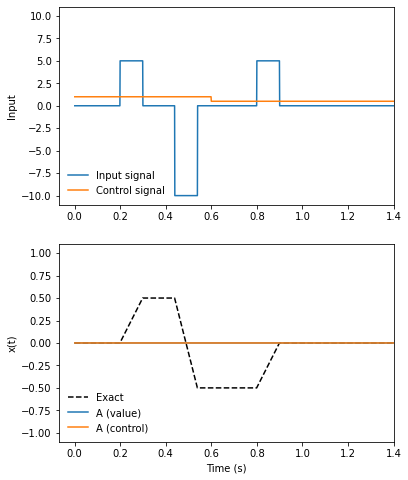

In [9]:
with nengo.Simulator(model) as sim:
    ablate_ensemble(ens, 1.0, sim)
    sim.run(1.4)
plot()

If we remove the negative bias current,
we can see that the neurons still have background activity,
but do not respond to input.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

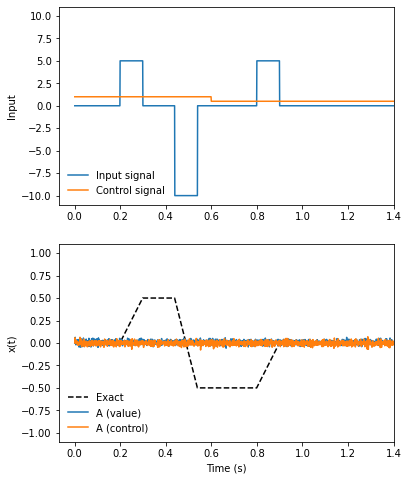

In [10]:
with nengo.Simulator(model) as sim:
    ablate_ensemble(ens, 1.0, sim, bias=False)
    sim.run(1.4)
plot()